This notebook contains the reproduction of the power curves in figure 2 of the paper "Discovering and Deciphering Relationships Across Disparate Data Modalities". Plots here include: 
* the difference between the power computed using ``mgcpy`` and the paper results, using data pre-generated with the matlab code in the github repository ``mgc-paper``
* partially completed power curves generated using ``mgcpy``

### How to add new power curves?
* Read the comments in the following functions and make edits accordingly
    * For power curves with increasing dimensions
        * fill_params_dict_list_dimensions()
    * For power curves with increasing sample size
        * fill_params_dict_list_sample_size()
    * plot_all_curves for plotting
* Run the block of code as indicated in markdown
* Note that you don't need to run all the previous tests e.g. mgc, dcorr, etc. They are already stored.

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from numpy import genfromtxt
import pandas as pd
from sklearn.externals.joblib import Parallel, delayed
import multiprocessing as mp
import scipy.io
#from tqdm import tqdm_notebook as tqdm
import h5py
import math
from scipy.ndimage.filters import gaussian_filter1d

In [2]:
sns.color_palette('Set1')
sns.set(color_codes=True, style='white', context='talk', font_scale=2)

In [3]:
import sys
module_path = '/Users/spanda/Essential/580.638 - NeuroData II/mgcpy'
if module_path not in sys.path:
    sys.path.append(module_path)
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.power import power, power_given_data
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [4]:
def find_dim(sim_name):
    dim = 0
    if sim_name in ['joint_normal', 'sine_4pi', 'sine_16pi', 'multi_noise']:
        dim = 10
    elif sim_name in ['step', 'spiral', 'circle', 'ellipse', 'quadratic', 'w_shape', 'two_parabolas', 'fourth_root']:
        dim = 20
    elif sim_name in ['multi_indept', 'bernoulli', 'log']:
        dim = 100
    elif sim_name in ['linear', 'exponential', 'cubic']:
        dim = 1000
    else:
        dim = 40
    return dim

In [5]:
simulations = {'joint_normal': (joint_sim, 4), 'sine_4pi': (sin_sim, 12), 'sine_16pi': (sin_sim, 13), 'multi_noise': (multi_noise_sim, 19),
               'step': (step_sim, 5), 'spiral': (spiral_sim, 8), 'circle': (circle_sim, 16), 'ellipse': (circle_sim, 17), 'diamond': (square_sim, 18),
               'log': (log_sim, 10), 'quadratic': (quad_sim, 6), 'w_shape': (w_sim, 7), 'two_parabolas': (two_parab_sim, 15), 'fourth_root': (root_sim, 11),
               'multi_indept': (multi_indep_sim, 20), 'bernoulli': (ubern_sim, 9), 'square': (square_sim, 14),
              'linear': (linear_sim, 1), 'exponential': (exp_sim, 2), 'cubic': (cub_sim, 3)
              }

In [6]:
def find_dim_range(dim):
    if dim < 20:
        lim = 10
    else:
        lim = 20
    
    dim_range = np.arange(math.ceil(dim/lim), dim+1, math.ceil(dim/lim))
    if math.ceil(dim/lim) != 1:
        dim_range= np.insert(dim_range, 0, 1)
        lim = dim_range.shape[0]
    return (lim, dim_range)

## Parallel code

In [7]:
def power_vs_dimension_parallel(params_dict):
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())

    dim = params_dict['dim']
    lim, dim_range = find_dim_range(dim)
    
    estimated_power = np.zeros(lim)
    for i in range(lim):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dim_range[i])
    
    np.savetxt('../mgcpy/benchmarks/python_power_curves_dimensions/fast_mgc/{}_{}_dimensions.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [8]:
def fill_params_dict_list_dimensions():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    rv_corr = RVCorr(which_test='rv')
    hhg = HHG()
    cca = RVCorr(which_test='cca')
    # initialize additional test
    # add the test that you wish to run in the `independence_tests` list
    independence_tests = [] #[mgc, mcorr, dcorr, mantel, rv_corr, cca] 
        
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1], 'dim': find_dim(sim_name)}
            params_dict_list.append(params_dict)
    return params_dict_list

In [9]:
def power_vs_sample_size_parallel(params_dict):
    sample_sizes = [i for i in range(5, 101, 5)]
    estimated_power = np.zeros(len(sample_sizes))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(sample_sizes)):
        estimated_power[i] = power_given_data(test, sim, data_type='sample_size', num_samples=sample_sizes[i], num_dimensions=1)
    
    np.savetxt('../mgcpy/benchmarks/python_power_curves_sample_size/fast_mgc/{}_{}_sample_size.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [10]:
def fill_params_dict_list_sample_sizes():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    hhg = HHG()
    pearson = RVCorr(which_test='pearson')
    independence_tests = [] #[mgc, mcorr, dcorr, mantel, pearson]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [11]:
def fast_power_vs_dimension_parallel(params_dict):
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())

    dim = params_dict['dim']
    lim, dim_range = find_dim_range(dim)
    
    estimated_power = np.zeros(lim)
    for i in range(lim):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dim_range[i])
    
    np.savetxt('../mgcpy/benchmarks/python_power_curves_dimensions/fast_mgc/{}_{}_dimensions.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [12]:
def fast_fill_params_dict_list_dimensions():
    mgc = MGC()
    # initialize additional test
    # add the test that you wish to run in the `independence_tests` list
    independence_tests = []
        
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1], 'dim': find_dim(sim_name)}
            params_dict_list.append(params_dict)
    return params_dict_list

In [13]:
def fast_power_vs_sample_size_parallel(params_dict):
    sample_sizes = [i for i in range(5, 101, 5)]
    estimated_power = np.zeros(len(sample_sizes))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    is_fast = True
    for i in range(len(sample_sizes)):
        estimated_power[i] = power_given_data(test, sim, data_type='sample_size', num_samples=sample_sizes[i], num_dimensions=1, additional_params={"is_fast": True})
    
    np.savetxt('../mgcpy/benchmarks/python_power_curves_sample_size/fast_mgc/{}_{}_sample_size.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [14]:
def fast_fill_params_dict_list_sample_sizes():
    mgc = MGC()
    independence_tests = []
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

Run the following block (if for increasing sample size, change functions accordingly)

In [15]:
%%time
params_dict = fast_fill_params_dict_list_sample_sizes()
pool = mp.Pool(mp.cpu_count()-1)
#results = pool.map(power_vs_dimension_parallel, params_dict)
results = pool.map(fast_power_vs_sample_size_parallel, params_dict)

CPU times: user 11.5 ms, sys: 24 ms, total: 35.5 ms
Wall time: 33.7 ms


In [19]:
# for any additional test, add the name of the test (as defined in the `get_name` function in the class)
# in the list `tests` in the following function
def plot_all_curves(which_type):
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                         'bernoulli', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
    plot_titles = ['Linear', 'Exponential', 'Cubic','Joint Normal', 'Step', 'Quadratic', 'W-Shaped', 'Spiral', 
                         'Uncorrelated\nBernoulli', 'Logarithmic', 'Fourth Root', 'Sine (4$\pi$)',
                       'Sine (16$\pi$)', 'Square', 'Two Parabolas', 'Circle', 'Ellipse', 'Diamond', 'Multiplicative\nNoise',
                        'Multimodal\nIndependence']
        
        
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(28,24))  
    simulation_type = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            simulation_type += 1
            if which_type == 'dimension':
                tests = ['mgc', 'unbiased', 'biased', 'mantel', 'hhg', 'rv', 'cca', 'mdmr', 'fast_mgc', 'fast_unbiased']
                test_names = ['MGC', 'Unbiased Dcorr', 'Biased Dcorr', 'Mantel', 'HHG', 'RV', 'CCA', 'MDMR', 'Fast MGC', 'Fast Dcorr']
                dir_name = '../mgcpy/benchmarks/python_power_curves_dimensions/'
                if simulation_type in [1, 2, 3]:
                    tests.remove('mdmr')
                    test_names.remove('MDMR')
                #mgc_power = np.genfromtxt(dir_name + '{}_mgc_dimensions.csv'.format(simulation_type), delimiter=',')

                count = 0;
                for test in tests:
                    power = np.genfromtxt(dir_name + '{}_{}_dimensions.csv'.format(simulation_type, test), delimiter=',')
                    _, dim_range = find_dim_range(find_dim(sim_name))
                    x_axis = dim_range
                    power_new = gaussian_filter1d(power, sigma=0.75)
                    if test == 'mgc':
                        col.plot(x_axis, power_new, label=test_names[count], lw=5, color='red')
                    elif test == 'fast_mgc':
                        col.plot(x_axis, power_new, label=test_names[count], lw=5, color='red', linestyle=':')
                    elif test == 'unbiased':
                        col.plot(x_axis, power_new, label=test_names[count], lw=3, color='blue')
                    elif test == 'fast_unbiased':
                        col.plot(x_axis, power_new, label=test_names[count], lw=3, color='blue', linestyle=':')
                    else:
                        col.plot(x_axis, power_new, label=test_names[count], lw=3)
                    col.set_xticks([x_axis.min(), x_axis.max()])
                    col.set_ylim(0, 1.05)
                    if simulation_type == 1 or simulation_type == 6 or simulation_type == 11 or simulation_type == 16:
                        col.set_yticks([0, 1])
                    else:
                        col.set_yticks([])
                    col.set_title(plot_titles[simulation_type-1], fontsize=35)
                    count += 1;
                    #file = open('../../NeuroData/power_curve_{}.pkl'.format(sim_name),  'rb')
            else:
                tests = ['mgc', 'unbiased', 'biased', 'mantel', 'pearson', 'mdmr', 'fast_mgc', 'hhg', 'fast_unbiased']
                test_names = ['MGC', 'Unbiased Dcorr', 'Biased Dcorr', 'Mantel', 'Pearson', 'MDMR', 'Fast MGC', 'HHG', 'Fast Dcorr']
                dir_name = '../mgcpy/benchmarks/python_power_curves_sample_size/'
                #mgc_power = np.genfromtxt(dir_name + '{}_mgc_sample_size.csv'.format(simulation_type), delimiter=',')

                count = 0;
                for test in tests:
                    power = np.genfromtxt(dir_name + '{}_{}_sample_size.csv'.format(simulation_type, test), delimiter=',')
                    x_axis = [i for i in range(5, 101, 5)]
                    power_new = gaussian_filter1d(power, sigma=0.75)
                    # fast mgc is invalid for sample size less than 20
                    if test == 'fast_mgc':
                        power[0:3] = np.nan
                    if test == 'mgc':
                        col.plot(x_axis, power_new, label=test_names[count], lw=5, color='red')
                    elif test == 'fast_mgc':
                        col.plot(x_axis, power_new, label=test_names[count], lw=5, color='red', linestyle=':')
                    elif test == 'unbiased':
                        col.plot(x_axis, power_new, label=test_names[count], lw=3, color='blue')
                    elif test == 'fast_unbiased':
                        col.plot(x_axis, power_new, label=test_names[count], lw=3, color='blue', linestyle=':')
                    else:
                        col.plot(x_axis, power_new, label=test_names[count], lw=3)
                    col.set_xticks([x_axis[0], x_axis[-1]])
                    col.set_ylim(0, 1.05)
                    if simulation_type == 1 or simulation_type == 6 or simulation_type == 11 or simulation_type == 16:
                        col.set_yticks([0, 1])
                    else:
                        col.set_yticks([])
                    col.set_title(plot_titles[simulation_type-1], fontsize=35) 
                    count += 1;
    leg = plt.legend(bbox_to_anchor=(0.5, 0.1), bbox_transform=plt.gcf().transFigure, ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    plt.subplots_adjust(hspace=.75)
    #if which_type == 'dimension':
        #fig.suptitle('Power of Independence Tests for Increasing Dimensions', fontsize=30)
        # plt.savefig('../../../../Desktop/Neuro Data Design/power_curves_dimensions')
    #else:
        #fig.suptitle('Power of Independence Tests for Increasing Sample Size', fontsize=30)
        # plt.savefig('../../../../Desktop/Neuro Data Design/power_curves_sample_size')

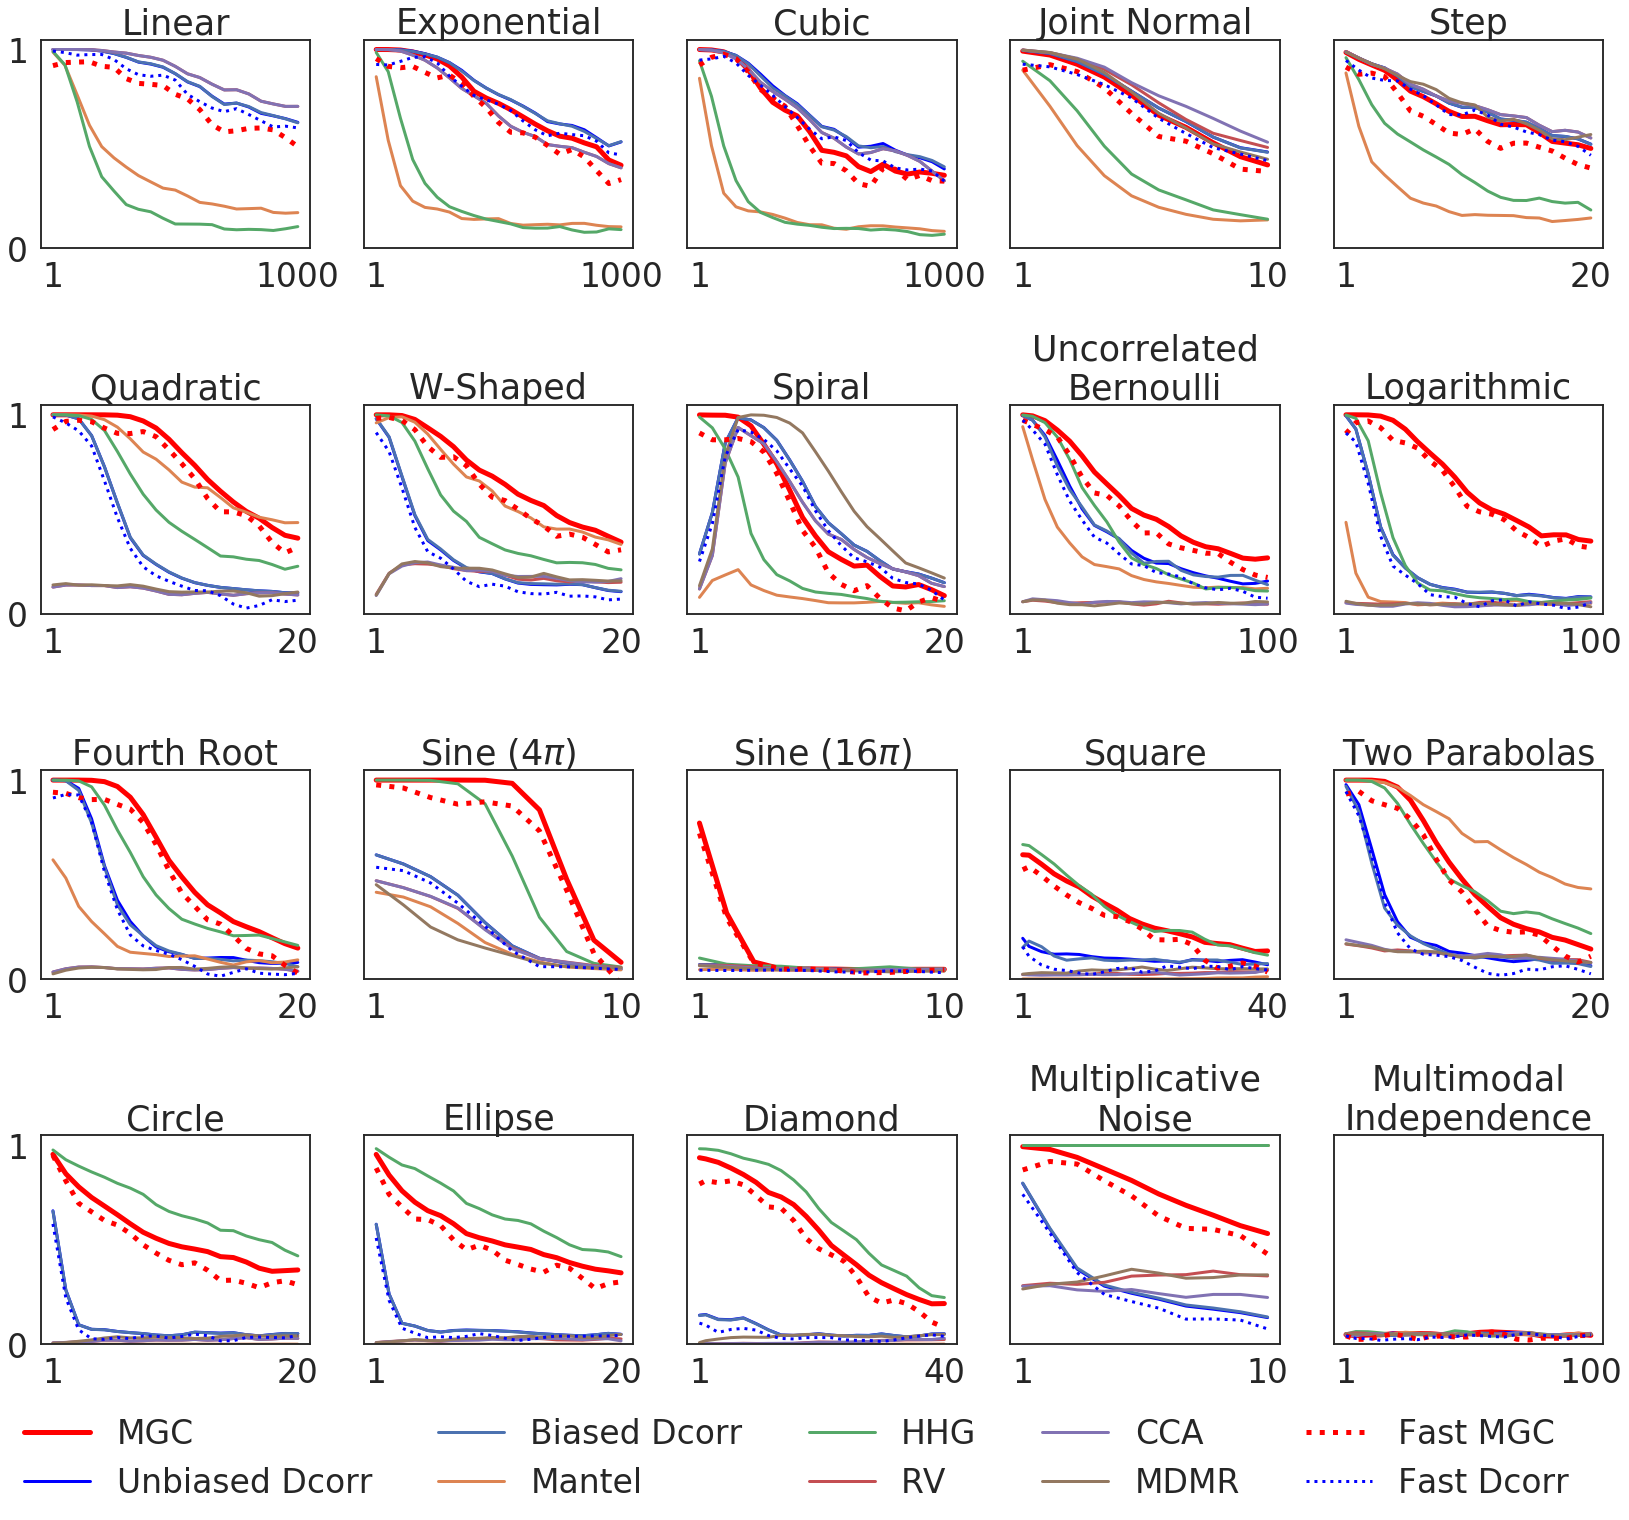

In [20]:
plot_all_curves('dimension')
plt.savefig('power_vs_dimension.eps', bbox_inches='tight')

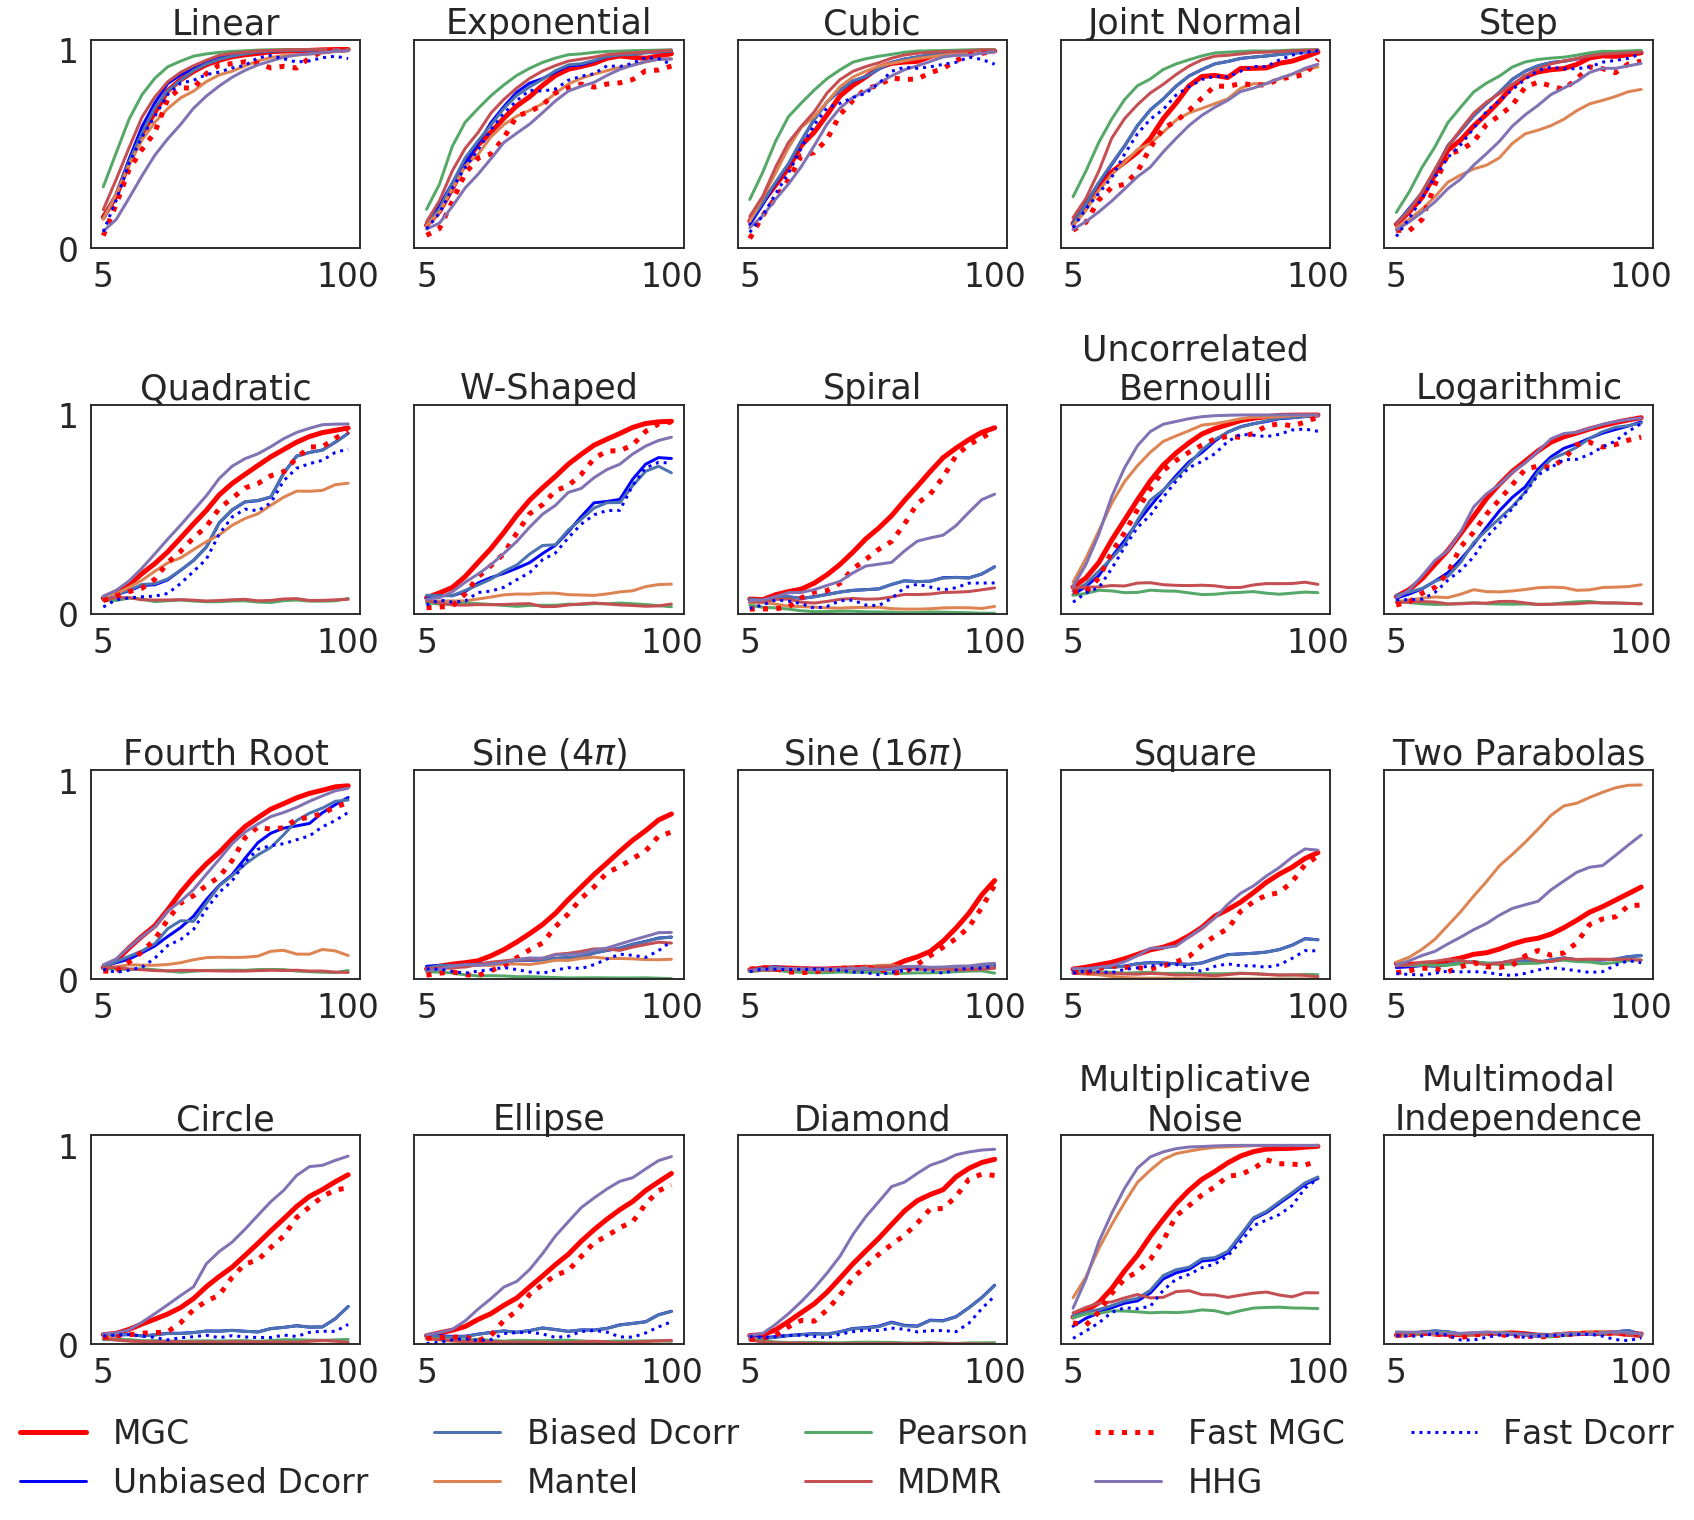

In [21]:
plot_all_curves('sample_size')
plt.savefig('power_vs_sample_size.eps', bbox_inches='tight')

In [19]:
def plot_diff_curves(which_type):
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                         'bernoulli', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
        
    dir_name = '../mgcpy/benchmarks/matlab_power_results/'
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14,12))  
    simulation_type = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            simulation_type += 1
            if which_type == 'dimension':
                tests = ['mgc', 'unbiased', 'biased', 'mantel', 'hhg', 'rv', 'cca']
                python_results_dir_name = '../mgcpy/benchmarks/python_power_curves_dimensions/'
                
                matlab_file_name = dir_name + 'dimension/CorrIndTestDimType{}N100Dim.mat'.format(simulation_type)
                # .mat files are in different versions and require different file readers
                if simulation_type in [1, 2, 13, 14, 15, 16]:
                    with h5py.File(matlab_file_name, 'r') as f:
                        matlab_results = {}
                        for k, v in f.items():
                            matlab_results[k] = np.transpose(np.array(v))
                else:
                    matlab_results = scipy.io.loadmat(matlab_file_name)
                        
                for test in tests:
                    python_power = np.genfromtxt(python_results_dir_name + '{}_{}_dimensions.csv'.format(simulation_type, test), delimiter=',')
                    _, dim_range = find_dim_range(find_dim(sim_name))
                    x_axis = dim_range
                    
                    # get the corresponding matlab result
                    matlab_str_code = ''
                    if test == 'mgc':
                        matlab_str_code = 'MGC'
                    elif test == 'unbiased':
                        matlab_str_code = 'M'
                    elif test == 'biased':
                        matlab_str_code = 'D'
                    elif test == 'mantel':
                        matlab_str_code = 'P'
                    elif test == 'hhg':
                        matlab_str_code = 'HHG'
                    elif test == 'rv':
                        matlab_str_code = 'Corr'
                    elif test == 'cca':
                        matlab_str_code = 'CCA'
                    matlab_power = matlab_results['power{}'.format(matlab_str_code)][0,:]
                    
                    col.plot(x_axis, python_power-matlab_power, label=test)
                    col.set_ylim(-1, 1)
                    #col.set_yticks([])
                    col.set_title(sim_name)
                    #file = open('../../NeuroData/power_curve_{}.pkl'.format(sim_name),  'rb')
            elif which_type == 'sample_size':
                tests = ['mgc', 'unbiased', 'biased', 'mantel', 'hhg', 'pearson']
                python_results_dir_name = '../mgcpy/benchmarks/python_power_curves_sample_size/'
                
                matlab_file_name = dir_name + 'sample_size/CorrIndTestType{}N100Dim1.mat'.format(simulation_type)
                # .mat files are in different versions and require different file readers
                #if simulation_type in [1, 2, 13, 14, 15, 16]:
                with h5py.File(matlab_file_name, 'r') as f:
                    matlab_results = {}
                    for k, v in f.items():
                        matlab_results[k] = np.transpose(np.array(v))
                        
                for test in tests:
                    python_power = np.genfromtxt(python_results_dir_name + '{}_{}_sample_size.csv'.format(simulation_type, test), delimiter=',')
                    x_axis = [i for i in range(5, 101, 5)]
                    
                    # get the corresponding matlab result
                    matlab_str_code = ''
                    if test == 'mgc':
                        matlab_str_code = 'MGC'
                    elif test == 'unbiased':
                        matlab_str_code = 'M'
                    elif test == 'biased':
                        matlab_str_code = 'D'
                    elif test == 'mantel':
                        matlab_str_code = 'P'
                    elif test == 'hhg':
                        matlab_str_code = 'HHG'
                    elif test == 'pearson':
                        matlab_str_code = 'Corr'
                    matlab_power = matlab_results['power{}'.format(matlab_str_code)][0,:]
                    
                    col.plot(x_axis, python_power-matlab_power, label=test)
                    col.set_ylim(-.2, .2)
                    #col.set_yticks([])
                    col.set_title(sim_name)
                    #file = open('../../NeuroData/power_curve_{}.pkl'.format(sim_name),  'rb')
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    if which_type == 'dimension':
        fig.suptitle('Difference between Python and Matlab Implemention (Python minus Matlab) of Power with Increasing Dimensions')
        #plt.savefig('../../../../Desktop/Neuro Data Design/diff_power_dimensions.png')
    else:
        fig.suptitle('Difference between Python and Matlab Implemention (Python minus Matlab) of Power with Increasing Sample Size')
        #plt.savefig('../../../../Desktop/Neuro Data Design/diff_power_sample_size.png')

ValueError: operands could not be broadcast together with shapes (21,3) (21,) 

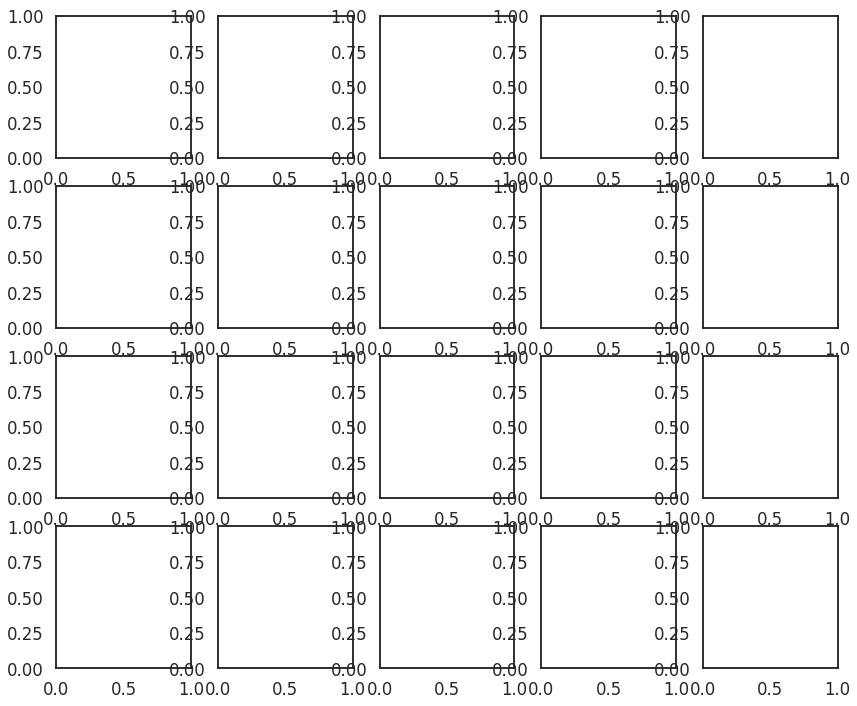

In [20]:
plot_diff_curves('dimension')

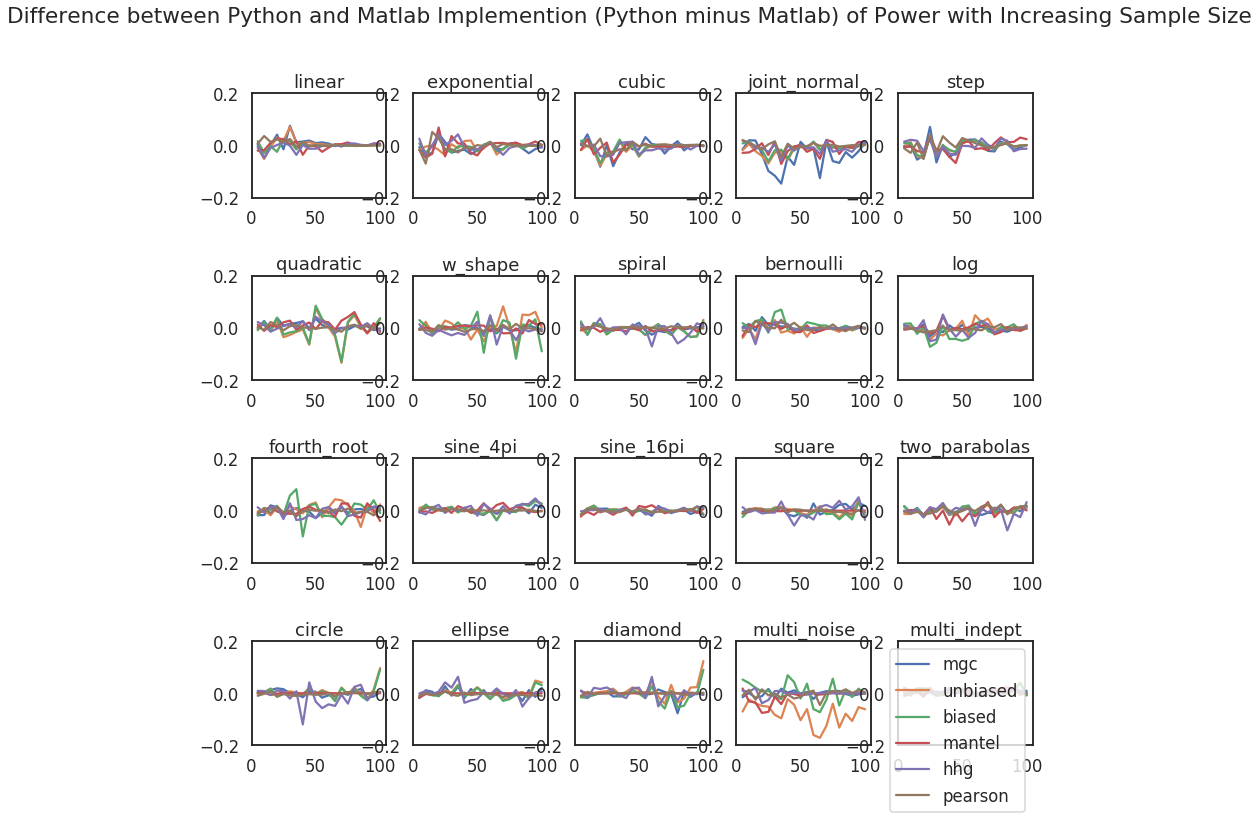

In [21]:
plot_diff_curves('sample_size')